<a href="https://colab.research.google.com/github/etalab-ia/ami-ia/blob/master/notebooks/intro-ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction à l'apprentissage supervisé

Une introduction au *machine learning* avec l'examples des données de contrôles sanitaires de la direction générale de l'alimentation : https://www.data.gouv.fr/fr/datasets/resultats-des-controles-officiels-sanitaires-dispositif-dinformation-alimconfiance/.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

%matplotlib inline

## 1. Importation et exploration des données

### Importer un jeu de données

Grâce à la librairie pandas. Par exemple, depuis internet.


In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/etalab-ia/ami-ia/master/data/export_alimconfiance.csv',
                 sep=';')

Quelle est la taille de mes données ?

In [3]:
df.shape

(38634, 13)

### A quoi ressemble mon jeu de données ?


In [4]:
df.sample(5)

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite
33908,LE JARDIN DU VAL,42467832400015,95100.0,Argenteuil,19-084916-1,2019-12-17T01:00:00+01:00,Boucherie-Charcuterie,Satisfaisant,NaN,"48.944926,2.207438",Boucherie-Charcuterie,25 rue des Grives,Autres
30790,MIDI VIANDES,38480603000035,83260.0,La Crau,19-105066-1,2019-11-26T01:00:00+01:00,Transformation de produits carnés,Très satisfaisant,83047003,"43.14235,6.056487",NaN,route de Toulon,Viandes et produits carnés
24780,LA FERME DU MOULIN SAINT JACQUES,49062500100022,97121.0,Anse-Bertrand,19-094318-1,2019-09-12T02:00:00+02:00,Centre d'emballage des oeufs,Satisfaisant,97102001,"16.4868468783,-61.4697680943",NaN,BP 164,Œufs et ovoproduits
29634,SOCIETE EUROPEENNE DE PATISSERIE,38053782900018,93120.0,La Courneuve,20-025383-1,2020-03-10T01:00:00+01:00,Boulangerie-Pâtisserie,A améliorer,NaN,"48.92252,2.383716",Boulangerie-Pâtisserie,40 BOULEVARD PASTEUR,Autres
36578,Napoli Mia,33942423600018,84000.0,Avignon,19-051633-1,2019-06-07T02:00:00+02:00,Restaurant,Satisfaisant,NaN,"43.942753,4.820783",Restaurant,8 ter route de Montfavet,Autres


Quels types de données ?


In [5]:
df.dtypes

APP_Libelle_etablissement              object
SIRET                                  object
Code_postal                           float64
Libelle_commune                        object
Numero_inspection                      object
Date_inspection                        object
APP_Libelle_activite_etablissement     object
Synthese_eval_sanit                    object
Agrement                               object
geores                                 object
filtre                                 object
ods_adresse                            object
ods_type_activite                      object
dtype: object

### Explorer le contenu de chaque colonne

Quels résultats pour les contrôles ?

In [6]:
df['Synthese_eval_sanit'].value_counts()

Satisfaisant                     20122
Très satisfaisant                15732
A améliorer                       2647
A corriger de manière urgente      133
Name: Synthese_eval_sanit, dtype: int64

Quels types d'établissements ?

In [7]:
df['filtre'].value_counts()

Restaurant                                                                                        14800
Restauration collective                                                                            6449
Boucherie-Charcuterie                                                                              1519
Boulangerie-Pâtisserie                                                                             1058
Alimentation générale                                                                               938
                                                                                                  ...  
Chocolatier|Glacier                                                                                   1
Boucherie-Charcuterie|Fromagerie|Glacier|Poissonnerie                                                 1
Boucherie-Charcuterie|Boulangerie-Pâtisserie|Fromagerie|Glacier                                       1
Rayon boucherie-charcuterie|Rayon pain/viennoiserie/pâtisserie|R

Certaines établissements appartiennent à plusieurs types, mais quelle proportion ?

In [8]:
(df['filtre'].str.contains('\|')).sum() / len(df)

0.014624424082414454

On fait le choix (arbitraire) de ne garder que le premier

In [0]:
df['filtre'] = df['filtre'].str.split('\|').str[0]

Et à quoi correspond la colonne `ods_type_activite` ?


In [10]:
df['ods_type_activite'].value_counts()

Autres                                              29744
Viandes et produits carnés                           2685
Produits de la mer et d'eau douce                    1789
Lait et produits laitiers                            1587
Abattoirs                                            1446
Transport et entreposage de denrées alimentaires     1021
Œufs et ovoproduits                                   362
Name: ods_type_activite, dtype: int64

Où se situent les contrôles ?

In [11]:
df['latitude'] = df['geores'].str.split(',').str[0].astype(float)
df['longitude'] = df['geores'].str.split(',').str[1].astype(float)
df.sample(1)

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite,latitude,longitude
2287,L'APEROTHERAPEUTE (L'APEROTHERAPEUTE),84961868100019,14830.0,LANGRUNE SUR MER,15436427,2020-01-15T01:00:00+01:00,_,Satisfaisant,NaN,"49.325161,-0.369683",NaN,52 RUE DU GENERAL LECLERC,Autres,49.325161,-0.369683


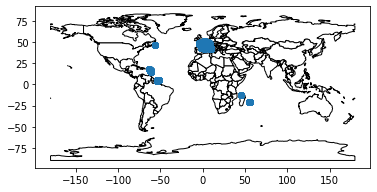

In [12]:
# !pip install geopandas
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df['longitude'], df['latitude']))
gdf.plot(ax=base)

Exploration de l'étrange colonne `Agrement`

In [13]:
df['Agrement'].count() / len(df['Agrement'])

0.2351037945850805

## 2. Feature engineering

Le feature engineerng consiste choisir quelles features conserver, en ajouter de nouvelles, et les transformer sous un format adapté pour l'entraînement des modèles. Contrairement à ce qu'on peut penser, **c'est la phase la plus complexe et la plus longue.**

A garder en tête : les algorithmes d'apprentissage, supervisés ou non, **ne savent travailler qu'avec des données numériques.**

#### Simplifions notre valeur cible sous un format numérique

In [14]:
simplification = {'Très satisfaisant': 1,
                  'Satisfaisant': 1,
                  'A améliorer': 0,
                  'A corriger de manière urgente': 0}
df['Synthese_eval_sanit'] = df['Synthese_eval_sanit'].map(simplification)
df['Synthese_eval_sanit'].value_counts()

1    35854
0     2780
Name: Synthese_eval_sanit, dtype: int64

### Créer de nouvelles features

Utilisons l'agrément comme un marqueur de qualité

In [15]:
df['has_agrement'] = pd.notnull(df['Agrement']).astype(int)
df['has_agrement'].sample(1)

4129    0
Name: has_agrement, dtype: int64

Ne serait-il pas possible de prendre en compte les contrôles passés d'un restaurant ?

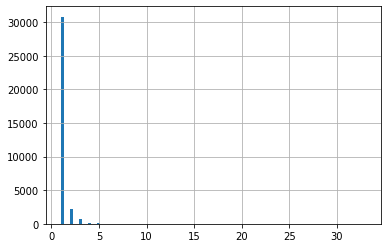

In [16]:
df['SIRET'].value_counts().hist(bins=100)

In [0]:
df['count_controls_siret'] = df.groupby('SIRET')['Synthese_eval_sanit'].transform(lambda x: x.count())

On peut aussi utiliser de l'information géographique, mais le niveau du code postal est trop précis.

Prenons plutôt les codes des départements.

In [18]:
df['Code_postal'].nunique()

5239

In [19]:
sum(df['Code_postal'].isnull())

23

In [20]:
df = df[df['Code_postal'].notnull()]
df['dept'] = np.floor(df['Code_postal'] / 1000)
df['dept'].sample(1)

31809    76.0
Name: dept, dtype: float64

On dispose de la date d'inspection : on peut donc en tirer de nouvelles features.

In [21]:
df['Date_inspection'].sample(1)

9137    2020-03-10T01:00:00+01:00
Name: Date_inspection, dtype: object

In [22]:
df['Date_inspection'] = pd.to_datetime(df['Date_inspection'],
                                       format='%Y-%m-%dT%H:%M:%S', utc=True)
df['Date_inspection'].sample(1)

23963   2020-03-03 00:00:00+00:00
Name: Date_inspection, dtype: datetime64[ns, UTC]

In [0]:
df['year'] = df['Date_inspection'].dt.year
df['month'] = df['Date_inspection'].dt.month
df['weekday'] = df['Date_inspection'].dt.weekday

Peut-on utiliser des informations transverses à plusieurs zones ou groupes ?

- Par département

In [0]:
df['count_controls_dept'] = df.groupby('dept')['Synthese_eval_sanit'].transform(lambda x: x.count())
df['score_controls_dept'] = df.groupby('dept')['Synthese_eval_sanit'].transform(lambda x: x.mean())

- Par secteur d'activité (Restaurant, Boucherie-Charcuterie, Boulangerie-Pâtisserie, etc.)

In [0]:
df['filtre'] = df['filtre'].fillna('NA')
df['count_controls_filtre'] = df.groupby('filtre')['Synthese_eval_sanit'].transform(lambda x: x.count())
df['score_controls_filtre'] = df.groupby('filtre')['Synthese_eval_sanit'].transform(lambda x: x.mean())

- Par type de produits vendus (Viandes et produits carnés, 
Produits de la mer et d'eau douce, Lait et produits laitiers, etc.)

In [0]:
df['ods_type_activite'] = df['ods_type_activite'].fillna('NA')
df['count_controls_activite'] = df.groupby('ods_type_activite')['Synthese_eval_sanit'].transform(
                                                                                   lambda x: x.count())
df['score_controls_activite'] = df.groupby('ods_type_activite')['Synthese_eval_sanit'].transform(
                                                                                   lambda x: x.mean())

- Par jour de la semaine !

In [0]:
df['count_controls_wday'] = df.groupby('weekday')['Synthese_eval_sanit'].transform(lambda x: x.count())
df['score_controls_wday'] = df.groupby('weekday')['Synthese_eval_sanit'].transform(lambda x: x.mean())

A quoi ressemblent nos ajouts ?

In [28]:
df.sample(1)

,APP_Libelle_etablissement,SIRET,Code_postal,Libelle_commune,Numero_inspection,Date_inspection,APP_Libelle_activite_etablissement,Synthese_eval_sanit,Agrement,geores,filtre,ods_adresse,ods_type_activite,latitude,longitude,geometry,has_agrement,count_controls_siret,dept,year,month,weekday,count_controls_dept,score_controls_dept,count_controls_filtre,score_controls_filtre,count_controls_activite,score_controls_activite,count_controls_wday,score_controls_wday
35632,"COMMUNAUTE DE COMMUNES DU CELLOIS, COE",20006975500011,79500.0,Marcillé,19-060142-1,2019-07-02 00:00:00+00:00,Restauration collective,1,NaN,"46.204047,-0.114799",Restauration collective,21 route des Ecoles,Autres,46.204047,-0.114799,POINT (-0.11480 46.20405),0,7,79.0,2019,7,1,220,0.972727,6444,0.950031,29728,0.921051,10146,0.927952


### Supprimer des features inutiles ou inutilisables

In [0]:
drop_cols = ['APP_Libelle_etablissement', 'Code_postal', 'SIRET', 'Libelle_commune',
             'APP_Libelle_activite_etablissement', 'Numero_inspection', 'Date_inspection',
             'Agrement', 'geores', 'ods_adresse', 'geometry']
df = df.drop(drop_cols, axis=1)

### Encoder les colonnes catégorielles

Il est nécessaire de transformer les catégories en nombres. Mais comment faire ?

| Etablissement | Activité           |
| :------ | :-------------     | 
| A       | Restaurant         |
| B       | Producteur Fermier |
| C       | Boucherie          |
| D       | Restaurant         |

devient :

| Etablissement | Activité_Restaurant | Activité_ProducteurFermier | Activité_Boucherie |
| :------ | :-: | :-: | :-: | 
| A       | 1 | 0 | 0 |
| B       | 0 | 1 | 0 |
| C       | 0 | 0 | 1 |
| D       | 1 | 0 | 0 |


- **Etape 1 :** on transforme les features à encoder sous format de catégories

In [0]:
# for c in categorical_features:
# df[c] = df[c].astype('category').cat.codes
# print('Nombre de catégories de la colonne "{}" : {}'.format(c, df[c].nunique()))
# df.sample(1)

- **Etape 2 :** on créer un encodeur, qui va directement transformer toutes les colonnes catégorielles

In [0]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = ['dept', 'filtre', 'ods_type_activite', 'month', 'weekday']
encoder = OneHotEncoder(drop='first', sparse=False).fit(df[categorical_features])

- **Etape 3 :** on fusionne les encodages avec le dataframe originel

In [32]:
df = pd.concat([df,
                pd.DataFrame(data=encoder.transform(df[categorical_features]), 
                             columns=encoder.get_feature_names(categorical_features), 
                             index=df.index)], axis=1)
df.shape

(38611, 156)

In [33]:
df.sample(1)

,Synthese_eval_sanit,filtre,ods_type_activite,latitude,longitude,has_agrement,count_controls_siret,dept,year,month,weekday,count_controls_dept,score_controls_dept,count_controls_filtre,score_controls_filtre,count_controls_activite,score_controls_activite,count_controls_wday,score_controls_wday,dept_2.0,dept_3.0,dept_4.0,dept_5.0,dept_6.0,dept_7.0,dept_8.0,dept_9.0,dept_10.0,dept_11.0,dept_12.0,dept_13.0,dept_14.0,dept_15.0,dept_16.0,dept_17.0,dept_18.0,dept_19.0,dept_20.0,dept_21.0,dept_22.0,...,filtre_Boulangerie-Pâtisserie,filtre_Chocolatier,filtre_Fromagerie,filtre_Glacier,filtre_Libre service,filtre_NA,filtre_Poissonnerie,filtre_Primeur,filtre_Rayon boucherie-charcuterie,filtre_Rayon fromagerie,filtre_Rayon fruits & légumes,filtre_Rayon pain/viennoiserie/pâtisserie,filtre_Rayon poissonnerie,filtre_Rayon traiteur,filtre_Restaurant,filtre_Restauration collective,filtre_Traiteur,ods_type_activite_Autres,ods_type_activite_Lait et produits laitiers,ods_type_activite_Produits de la mer et d'eau douce,ods_type_activite_Transport et entreposage de denrées alimentaires,ods_type_activite_Viandes et produits carnés,ods_type_activite_Œufs et ovoproduits,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
7695,1,Restaurant,Autres,48.890165,2.359238,0,1,75.0,2020,2,2,5951,0.963872,14794,0.918886,29728,0.921051,7861,0.92431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 3. Entraîner et comparer des modèles

Une fois que nos données sont sélectionnées et mises en forme, la phase d'apprentissage consiste à choisir le modèle et à optimiser ses paramètres.

### Un dernier nettoyage du jeu de données

In [34]:
df.shape

(38611, 156)

Suppression des lignes contenant des NaN

In [35]:
df = df.dropna()
df.shape

(37448, 156)

Suppression des colonnes avec une seule valeur différente

In [36]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col, inplace=True, axis=1)
df.shape

(37448, 155)

### Séparation en jeux de données "train" et "test"

In [0]:
from sklearn.model_selection import train_test_split
features = [col for col in df.columns if col not in categorical_features
            and col != 'Synthese_eval_sanit']

df_train, df_test = train_test_split(df, test_size=0.2)

X_train = df_train[features]
y_train = df_train['Synthese_eval_sanit']

X_test = df_test[features]
y_test = df_test['Synthese_eval_sanit']

### Echantillonner pour équilibrer les classes


In [38]:
y_train.mean(), y_test.mean()

(0.928867080579478, 0.92630173564753)

Les deux catégories que nous cherchons à prédire ne sont pas équilibrées ! L'algorithme pourrait utiliser cette faille pour facilement obtenir de bons résultats.

In [39]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler()
X_train, y_train = sampler.fit_resample(X_train, y_train)
X_test, y_test = sampler.fit_resample(X_test, y_test)

y_train.mean(), y_test.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

(0.5, 0.5)

### Un modèle simple : la méthode des k plus proches voisins

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_model.score(X_test, y_test)

0.5996376811594203

### Un modèle plus avancé : l'arbre de décision

In [41]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=10)
dt_model.fit(X_train, y_train)
dt_model.score(X_test, y_test)

0.6286231884057971

L'arbre de décision présente l'intérêt d'être interprétable :

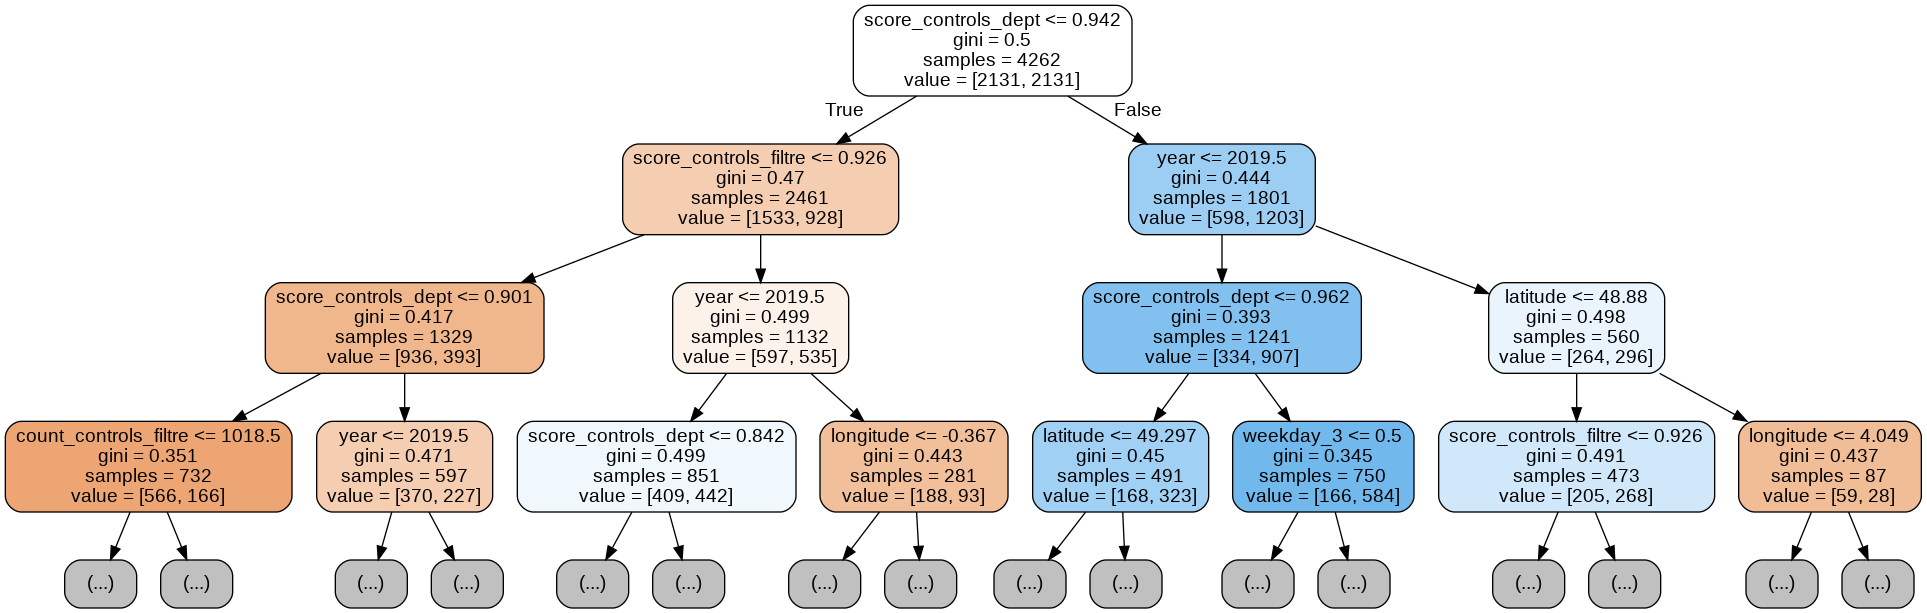

In [42]:
from io import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def plot_dt(dt, max_depth):
    dot_data = StringIO()
    export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, feature_names=features, max_depth=max_depth)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())
    
plot_dt(dt_model, max_depth=3)

### S'appuyer sur un ensemble de modèles

Et si on utilisait plutôt une forêt pleine d'arbres ?

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=8)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.6784420289855072

### La notion d'hyperparamètres

Le concept d'**hyperparamètres** : des paramètres que le modèle ne peut pas apprendre. Par exemple :
- la profondeur de l'arbre `max_depth`
- le nombre d'arbres dans la forêt `n_estimators`
- le nombre de voisins à considérer `n_neighbors`

Comment les optimiser ? En testant !

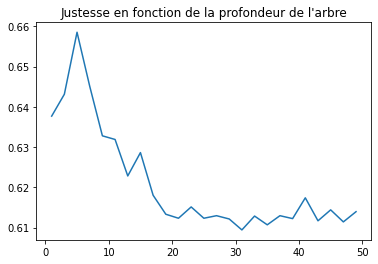

In [44]:
scores = []
steps = range(1, 51, 2)
for n in steps:
  repetitions = range(10)
  step_score = []
  for i in repetitions:
    model = DecisionTreeClassifier(max_depth=n)
    model.fit(X_train, y_train)
    step_score.append(model.score(X_test, y_test))
  scores.append(np.mean(step_score))
plt.plot(steps, scores)
plt.title("Justesse en fonction de la profondeur de l'arbre")
plt.show()

### Les réseaux de neurones

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nn_model = Sequential([
              Dense(124, name='hidden', activation='relu', input_shape=(len(features),)),
              Dense(1, name='output', activation='sigmoid'),
           ])

nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = nn_model.fit(X_train_norm, y_train, batch_size=200, epochs=100, validation_data=(X_test_norm, y_test))

Epoch 1/100
22/22 [==============================] - 0s 10ms/step - loss: 0.2425 - accuracy: 0.5814 - val_loss: 0.2323 - val_accuracy: 0.6377
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2261 - accuracy: 0.6527 - val_loss: 0.2208 - val_accuracy: 0.6603
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2157 - accuracy: 0.6736 - val_loss: 0.2145 - val_accuracy: 0.6685
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2097 - accuracy: 0.6856 - val_loss: 0.2113 - val_accuracy: 0.6522
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2059 - accuracy: 0.6851 - val_loss: 0.2112 - val_accuracy: 0.6639
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2032 - accuracy: 0.6985 - val_loss: 0.2088 - val_accuracy: 0.6612
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.2013 - accuracy: 0.6969 - val_loss: 0.2079 - val_accuracy: 0.6621
Epoch 8/100


### La notion d'overfitting

On peut visualiser l'évolution de la performance de lu réseau de neurones au cours de l'entraînement :

[]

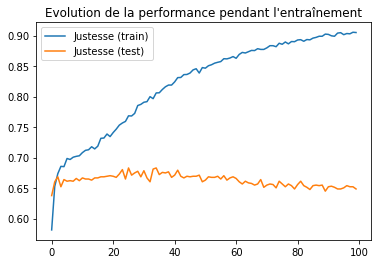

In [47]:
plt.plot(history.history['accuracy'], label='Justesse (train)')
plt.plot(history.history['val_accuracy'], label='Justesse (test)')
plt.title("Evolution de la performance pendant l'entraînement")
plt.legend()
plt.plot()

L'importante notion d'overfitting : lorsque l'algorithme "colle trop" aux données d'entraînement.

## 4. Tester et valider le modèle

On prédit en utilisant le modèle, sur les données de test non vues en entraînement



In [0]:
y_pred = rf_model.predict(X_test)
y_fake = np.random.choice([0, 1], size=len(y_test), p=[1 - y_test.mean(), y_test.mean()])

### Matrice de confusion



In [49]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Vrai label 0', 'Vrai label 1'], columns=['Label prédit 0', 'Label prédit 1'])

,Label prédit 0,Label prédit 1
Vrai label 0,376,176
Vrai label 1,179,373


### Utiliser différentes métriques

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

res = []
for metric in [accuracy_score, precision_score, recall_score, f1_score]:
  res.append([metric.__name__, metric(y_test, y_pred), metric(y_test, y_fake)])
pd.DataFrame(res, columns = ['Métrique', 'Score du modèle', "Score de l'aléatoire"])

,Métrique,Score du modèle,Score de l'aléatoire
0,accuracy_score,0.678442,0.484601
1,precision_score,0.679417,0.484794
2,recall_score,0.675725,0.490942
3,f1_score,0.677566,0.487849
